### Module 6

In [68]:
import numpy as np
import scipy.stats as sp
import statsmodels.api as smapi
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [140]:
# here we will code up the metropolis-hastings algo

def metro_hast(f_pdf, g_pdf, g_gen,ndraws = 100,init_value = None, *args,**kwargs):
    ### function to run the general metropolis-hastings algorithm
    ### inputs
    ### f_pdf: a function that returns the pdf f(x)
    ### g_pdf: a function that returns the candidate value g(x_1|x_0)
    ### g_gen: a function that returns a random variable drawn from g(x_1|x_0)
    ### n_samples: the number of samples we want to generate from
    
    # following the text, initialize the initial samples
    # the first one is our initial
    sim_samples = g_gen(ndraws+1,*args,**kwargs)
    
    # allow for an initialization value 
    if init_value is not None:
        sim_samples[0]=init_value
        
    # we pull all the uniform variables we need upfront
    unif_rv = sp.uniform.rvs(size=ndraws)
    acceptance = np.zeros(ndraws)
    accep_prob = lambda x1,x0: f_pdf(x1,x0,*args,**kwargs)*g_pdf(x0,x1,*args,**kwargs)/(f_pdf(x0,x1,*args,**kwargs)*g_pdf(x1,x0,*args,**kwargs))
    
    for i_sim in range(1,len(sim_samples+1)):
        y = sim_samples[i_sim]
        x = sim_samples[i_sim-1]
        p_acc = min(1,accep_prob(y,x))
        sim_samples[i_sim] = x+(y-x)*(unif_rv[i_sim-1]<=p_acc)
        if unif_rv[i_sim-1]<=p_acc:
            acceptance[i_sim-1]=1
                
    results = {'samples':sim_samples,'accept_rate':acceptance.sum()/ndraws}
    return results


def accept_reject(f_pdf,g_pdf,g_gen,M=1,ndraws=100,*args,**kwargs):
    # function to do the accept reject method
    # f_pdf is desired pdf to sample from
    # g_pdf is the candidate pdf function
    # g_geg is the function to generate a candidate value from distribution g_gen - we may have to use exotic densities
    # M is the scalar such that M>=sup(f(x)/g(x)) for all x
    
    sim_values = np.zeros(ndraws,)
    sim_success = 0 # python index starts at 0
    sim_idx = -1
    n_count=0
    
    while sim_success < ndraws:
        # draw a random value from g_gen
        cand_rv = g_gen(nobs=1,*args,**kwargs)
        # draw uniform random value bounded between 0 and M*cand_rand
        unif_rv = sp.uniform.rvs(loc=0,scale=g_pdf(cand_rv,*args,**kwargs)*M,size=1,)
        
        if unif_rv < f_pdf(cand_rv,):
            sim_success +=1
            sim_idx +=1
            sim_values[sim_idx]=cand_rv
        
        results={'samples':sim_values,'accept_rate':sim_success/ndraws} 
    return results   

### Problem 1 - (Ex 6.7 text)

In [144]:
def f_pdf_p1(x,*args,**kwargs):
    # if not specified then c and d are 0 and 1 and the pdf value is returned
    c = kwargs.get('c',0.)
    d = kwargs.get('d',1.)
    # allow for truncation for part b
    if x>=c and x<=d:
        return sp.beta.pdf(x,a=2.7,b=6.3)
    else:
        return 0

def g_pdf_beta(x,*args,**kwargs):
    # independent so only the first value matters
    a = kwargs.get('a',1)
    b = kwargs.get('b',1)
    return sp.beta.pdf(x,a=a,b=b)

def g_gen_beta(nobs,*args,**kwargs):
    a = kwargs.get('a',1)
    b = kwargs.get('b',1)
    return sp.beta.rvs(size=nobs,a=a,b=b)    

def g_pdf_unif(x,*args,**kwargs):
    c = kwargs.get('c',0.)
    d = kwargs.get('d',1.)
    return sp.uniform.pdf(x,loc=c,scale=d-c)

def g_gen_unif(nobs,*args,**kwargs):
    c = kwargs.get('c',0.)
    d = kwargs.get('d',1.)
    return sp.uniform.rvs(size=nobs,loc=c,scale=d-c)

beta_var = lambda a,b: a*b/(pow(a+b,2)*(a+b+1))


In [145]:
# 6.7(a)
b_rates = np.array([1,2,3,4,5,10,25,50,100])

get_accept = lambda a, b: metro_hast(f_pdf_p1,g_pdf_beta,g_gen_beta,1000,a=a,b=b)['accept_rate']

# iterating through and getting results
results = pd.DataFrame({b_:pd.Series({'rate':get_accept(1,b_),'var':beta_var(1,b_)}) for b_ in b_rates}).T
results.index.name = 'b'

In [147]:
# show the results
results
wrt_result = results.to_latex()
print(wrt_result)

\begin{tabular}{lrr}
\toprule
{} &   rate &       var \\
b   &        &           \\
\midrule
1   &  0.459 &  0.083333 \\
2   &  0.661 &  0.055556 \\
3   &  0.678 &  0.037500 \\
4   &  0.601 &  0.026667 \\
5   &  0.479 &  0.019841 \\
10  &  0.178 &  0.006887 \\
25  &  0.122 &  0.001370 \\
50  &  0.055 &  0.000370 \\
100 &  0.043 &  0.000096 \\
\bottomrule
\end{tabular}



In [148]:
# part B
beta1 = metro_hast(f_pdf_p1,g_pdf_beta,g_gen_beta,1000,init_value=0.5,a=2,b=6,c=0.1,d=0.9)
unif1 = metro_hast(f_pdf_p1,g_pdf_unif,g_gen_unif,1000,a=2,b=6,c=0.1,d=0.9)
beta2 = metro_hast(f_pdf_p1,g_pdf_beta,g_gen_beta,1000,init_value=0.5,a=2,b=6,c=0.25,d=0.75)
unif2 = metro_hast(f_pdf_p1,g_pdf_unif,g_gen_unif,1000,a=2,b=6,c=0.25,d=0.75)


In [193]:
a_rates = pd.Series({'b_10_90': beta1['accept_rate'],'b_25_75':beta2['accept_rate'],
                     'u_10_90':unif1['accept_rate'], 'u_25_75':unif2['accept_rate']})
a_results_wrt = a_rates.to_latex()
print(a_results_wrt)

\begin{tabular}{lr}
\toprule
{} &      0 \\
\midrule
b\_10\_90 &  0.740 \\
b\_25\_75 &  0.415 \\
u\_10\_90 &  0.507 \\
u\_25\_75 &  0.604 \\
\bottomrule
\end{tabular}



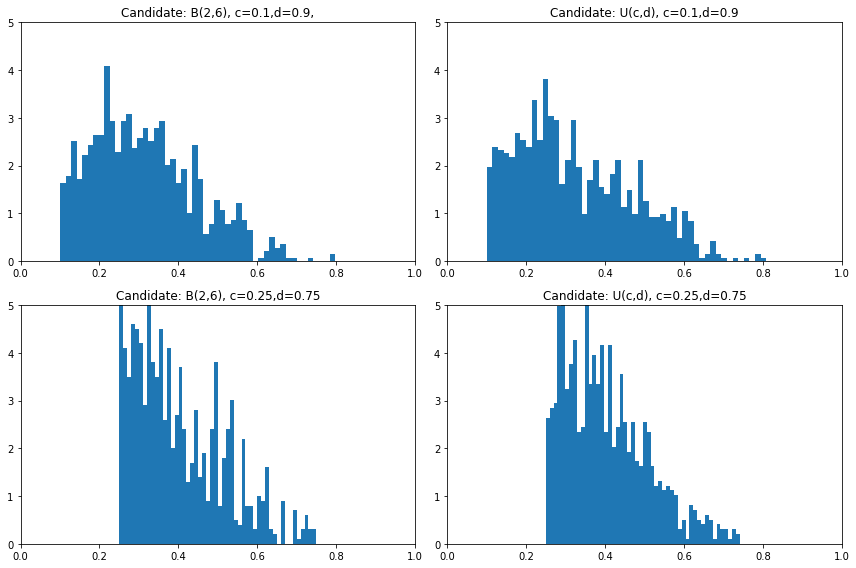

In [150]:
# plotting the data
fig_ = plt.figure(figsize=(12,8))
ax_ = plt.subplot(2,2,1)
ax_.hist(beta1['samples'],bins=50,density=True);
ax_.set_xlim(0,1)
ax_.set_ylim(0,5)
ax_.set_title('Candidate: B(2,6), c=0.1,d=0.9,')

ax_ = plt.subplot(2,2,2)
ax_.hist(unif1['samples'],bins=50,density=True);
ax_.set_xlim(0,1)
ax_.set_ylim(0,5)
ax_.set_title('Candidate: U(c,d), c=0.1,d=0.9')

ax_ = plt.subplot(2,2,3)
ax_.hist(beta2['samples'],bins=50,density=True);
ax_.set_xlim(0,1)
ax_.set_ylim(0,5)
ax_.set_title('Candidate: B(2,6), c=0.25,d=0.75')

ax_ = plt.subplot(2,2,4)
ax_.hist(unif2['samples'],bins=50,density=True);
ax_.set_xlim(0,1)
ax_.set_ylim(0,5)
ax_.set_title('Candidate: U(c,d), c=0.25,d=0.75')
plt.tight_layout()
plt.show()



##### Problem 2 (6.9 from the text)

In [75]:
def f_pdf_p2(x,*args,**kwargs):
    # the notation of the gamma distribution in python
    # is different than R. The scale (lambda) is 1/b
    # R convention is Gamma(a,b)
    dist = sp.gamma(a=4.3,scale=1/6.2)
    return dist.pdf(x)

def g_pdf_p2(x,*args,**kwargs):
    # independent so only the first value matters
    alpha = kwargs.get('alpha',4.3)
    beta = kwargs.get('beta',6.2)
    return sp.gamma.pdf(x,a=alpha,scale=1/beta)

def g_gen_p2(nobs=1,*args,**kwargs):
    alpha = kwargs.get('alpha',4.3)
    beta = kwargs.get('beta',6.2)
    return sp.gamma.rvs(size=nobs,a=alpha,scale=1/beta)



###### part a

Text(0, 0.5, 'f(x)')

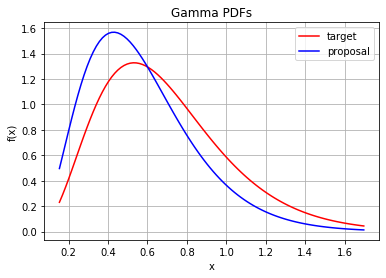

In [70]:
# prior to running the accept-reject algorithm we will plot the target and proposal
# together to intuit a reasonable M

g_target = sp.gamma(a=4.3,scale=1/6.2)
g_prop = sp.gamma(a=4,scale=1/7.)

# plotting one distribution over
# getting 100 x points from the target distribution
# the ppf gives us the x val, i.e the inverse cdf
x = np.linspace(g_target.ppf(0.01,),g_target.ppf(0.99),100)
ax_ =plt.axes()
ax_.plot(x,g_target.pdf(x),color='r',label='target')
ax_.plot(x,g_prop.pdf(x),color='b',label='proposal')
ax_.grid()
ax_.legend()
ax_.set_title('Gamma PDFs')
ax_.set_xlabel('x')
ax_.set_ylabel('f(x)')

In [167]:
# running the accept-reject algorithm
part_2a = accept_reject(f_pdf_p2,g_pdf_p2,g_gen_p2,M=8,ndraws=10000,alpha=4,beta=7)

SM:0.6959471334738544 Theoretical:0.6935483870967741


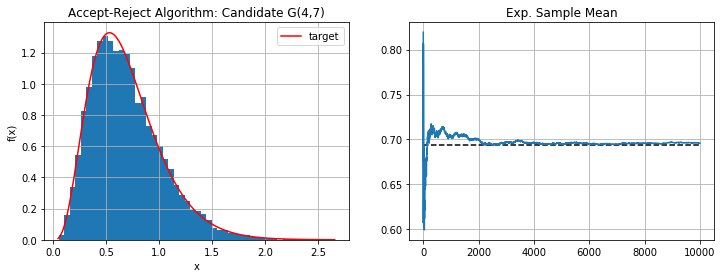

In [194]:
# plotting and summarizing results
part_2a_sm = pd.Series(part_2a['samples']).expanding().mean()
part_2a_mean = part_2a['samples'].mean()

x = np.linspace(g_target.ppf(0.0001,),g_target.ppf(0.9999),10000)
fig_ = plt.figure(figsize=(12,4))

ax_ = plt.subplot(1,2,1)
ax_.plot(x,g_target.pdf(x),color='r',label='target')
ax_.hist(part_2a['samples'],bins=50,density=True);
ax_.legend()
ax_.set_xlabel('x')
ax_.set_ylabel('f(x)')
ax_.set_title('Accept-Reject Algorithm: Candidate G(4,7)')
ax_.grid()

ax_ = plt.subplot(1,2,2)
part_2a_sm.plot()
ax_.grid()
ax_.set_title('Exp. Sample Mean')
ax_.hlines(y=4.3/6.2,xmin=0,xmax=10000,linestyle='--')
print('SM:{0} Theoretical:{1}'.format(part_2a_mean,4.3/6.2))


###### part 2b

In [175]:
part_2b = metro_hast(f_pdf_p2,g_pdf_p2,g_gen_p2,ndraws=10000,alpha=4,beta=7)

SM:0.6877828019166772 Theoretical:0.6935483870967741


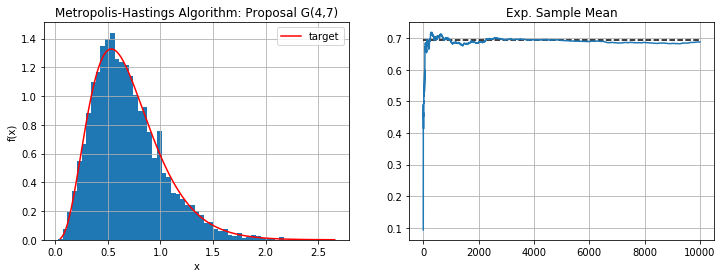

In [195]:
# plotting and summarizing results
part_2b_sm = pd.Series(part_2b['samples']).expanding().mean()
part_2b_mean = part_2b['samples'].mean()

x = np.linspace(g_target.ppf(0.0001,),g_target.ppf(0.9999),10000)
fig_ = plt.figure(figsize=(12,4))

ax_ = plt.subplot(1,2,1)
ax_.plot(x,g_target.pdf(x),color='r',label='target')
ax_.hist(part_2b['samples'],bins=50,density=True);
ax_.legend()
ax_.set_xlabel('x')
ax_.set_ylabel('f(x)')
ax_.set_title('Metropolis-Hastings Algorithm: Proposal G(4,7)')
ax_.grid()

ax_ = plt.subplot(1,2,2)
part_2b_sm.plot()
ax_.grid()
ax_.hlines(y=4.3/6.2,xmin=0,xmax=10000,linestyle='--')
ax_.set_title('Exp. Sample Mean')

print('SM:{0} Theoretical:{1}'.format(part_2b_mean,4.3/6.2))


###### Part 2c

In [155]:
part_2c = metro_hast(f_pdf_p2,g_pdf_p2,g_gen_p2,ndraws=10000,alpha=5,beta=6)

SM:0.6926437072816218 Theoretical:0.6935483870967741


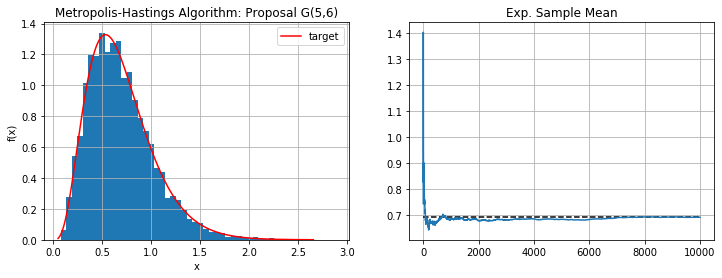

In [196]:
# plotting and summarizing results
part_2c_sm = pd.Series(part_2c['samples']).expanding().mean()
part_2c_mean = part_2c['samples'].mean()

x = np.linspace(g_target.ppf(0.0001,),g_target.ppf(0.9999),10000)
fig_ = plt.figure(figsize=(12,4))

ax_ = plt.subplot(1,2,1)
ax_.plot(x,g_target.pdf(x),color='r',label='target')
ax_.hist(part_2c['samples'],bins=50,density=True);
ax_.legend()
ax_.set_xlabel('x')
ax_.set_ylabel('f(x)')
ax_.set_title('Metropolis-Hastings Algorithm: Proposal G(5,6)')
ax_.grid()

ax_ = plt.subplot(1,2,2)
part_2c_sm.plot()
ax_.grid()
ax_.set_title('Exp. Sample Mean')
ax_.hlines(y=4.3/6.2,xmin=0,xmax=10000,linestyle='--')

print('SM:{0} Theoretical:{1}'.format(part_2c_mean,4.3/6.2))


In [177]:
sample_means = pd.DataFrame({'acc_rej':part_2a_sm,'met_hast_4_7':part_2b_sm,'met_hast_5_6':part_2c_sm})

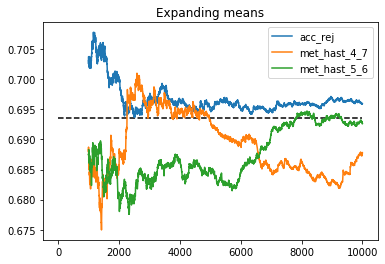

In [192]:
ax_ =sample_means[1000:].plot()
ax_.set_title('Expanding means')
ax_.hlines(y=4.3/6.2,xmin=0,xmax=10000,linestyle='--')
